In [1]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import plotly.express as px
import re
from datetime import datetime

from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import re
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType

from sklearn.linear_model import LinearRegression, LogisticRegression
#from scripts.VendorsParsingTools import *
#from scripts.ForumParsingTools import *
#from scripts.ProductListingParsingTools import *
from scripts.libs.milestone2Methods import *
#import geopandas
#import descartes
#import geoplot
#import shapefile as shp
#import calmap
import warnings; warnings.simplefilter('ignore')

# 1) General overview

## 1.0) Used datasets

###  agora

  - ##### Description
  The archive contains scraped html pages from the market's Vendor profiles, Listings, Category Lists, Listing pictures and User profiles. Only the Vendor profiles and the Category List of items were used.



###  agora-forums

  - ##### Description
  The archive contains scraped html pages from the forum's global stats, the topics, the topic list per board. Only the global stats and the topic lists per board were used.


###  grams

  - ##### Description
  The archive contains csv files of requests results obtained on the Grams platform for several services, a search engine for the DarkNet marketplaces. Only the results related to Agora were used.



### [_DNStats_](https://dnstats.net/)
  - #### Description
  The archive contains a single sql files containing the measured ping, http response, and other information made by the DNStats platform over almost 3 years for nearly all DarkNet services. It was promptly pared to retain only the requests made to Agora and Agora-Forum.

## 1.1) Files obtained for each day

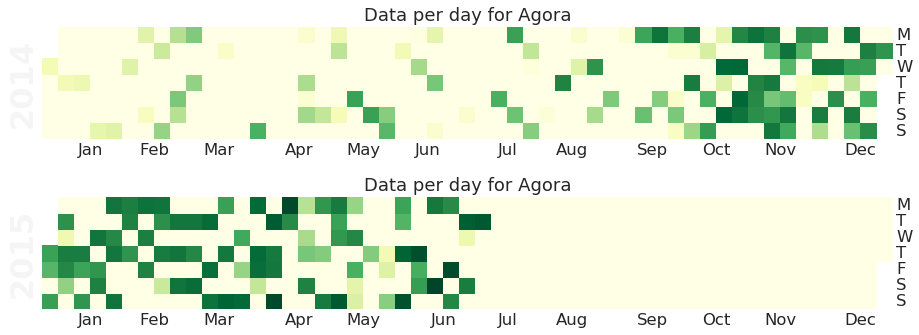

In [113]:
agora_df = pd.read_csv('../data/agora_filesnum.out')
forum_df = pd.read_csv('../data/agora-forum_filesnum.out')
all_days_df = generateFileCount(forum_df, agora_df)
events_ag = pd.Series(all_days_df['filenum_ag'])
events_for = pd.Series(all_days_df['filenum_for'])
calmap.calendarplot(events_ag, daylabels='MTWTFSS', cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0, fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora'});

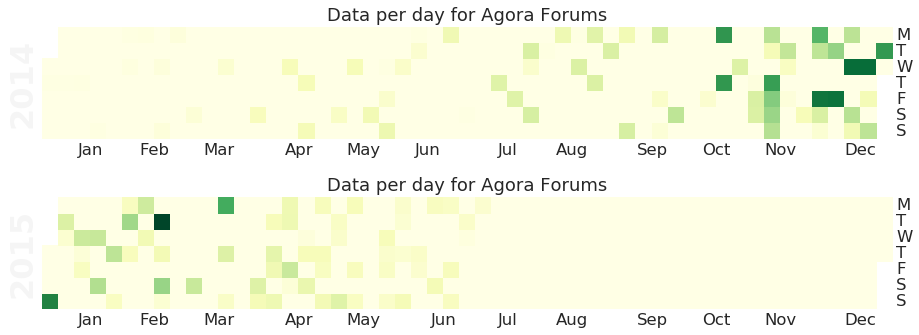

In [114]:
calmap.calendarplot(events_for,daylabels='MTWTFSS',cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0,fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora Forums'});

>This calendars map show the amount of data per day we have for Agora and Agora Forum. We clearly have a satisfactory amount of data for the market, but we dont have a reliable amount for the forum. There is no stable web scrapping of both websites. In order to understand better this problem, we will study the uptime average of both services in the next part.

## 1.2) Services Uptime

> We then decide to use DNStats which is an up-to-date site tracking darknet markets, products, vendors, news, and more. This way, we can track the amount of available files for each days for Agora depending on the uptime of the sercices, or even see if the Onymous operation had an impact on the services uptime. 


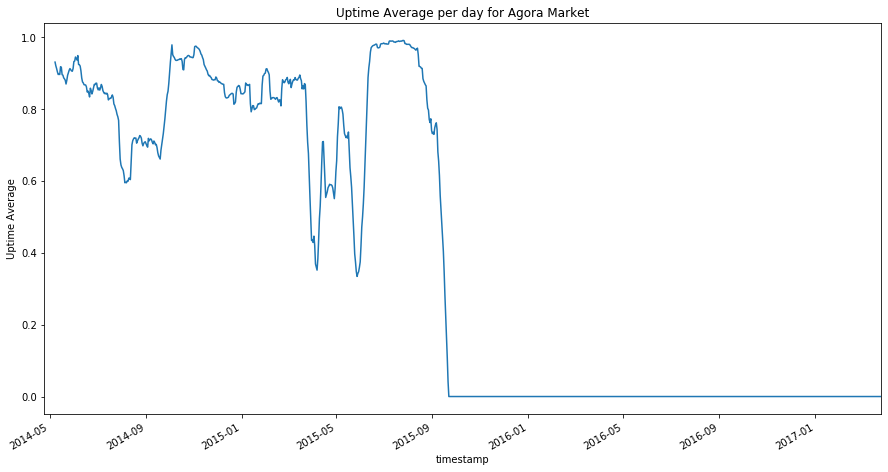

In [26]:
agora_df1 = pd.read_csv('data/agora_stats.out', sep=",")
agora_df1 = agora_df1.drop(columns=['rid', 'speed_download', 'total_time'])
agora_df1['timestamp'] = agora_df1['timestamp'].apply(pd.to_datetime)

agora_df1['siteup'] = agora_df1['httpcode'].apply(fixIsUp)
agora_df1['timestamp'] = agora_df1['timestamp'].apply(truncateTime)

agora_subdf1 = agora_df1[agora_df1['sitename'] == "Agora"]
forum_subdf1 = agora_df1[agora_df1['sitename'] == "Agora Forums"]

agora_subdf1 = agora_subdf1.groupby(by='timestamp').mean()
forum_subdf1 = forum_subdf1.groupby(by='timestamp').mean()

def plotUptime(df, title, win=15):
    fig, ax1 = plt.subplots( figsize=(15,8))
    ax1.set_xlabel('date (d)')
    ax1.set_ylabel('Uptime Average')
    df.rolling(window=win).mean().plot(
          kind='line', x='a',y='b', use_index=True)
    ax1.tick_params(axis='y')
    plt.title(title)
    plt.show()
    
plotUptime(agora_subdf1['siteup'], 'Uptime Average per day for Agora Market')

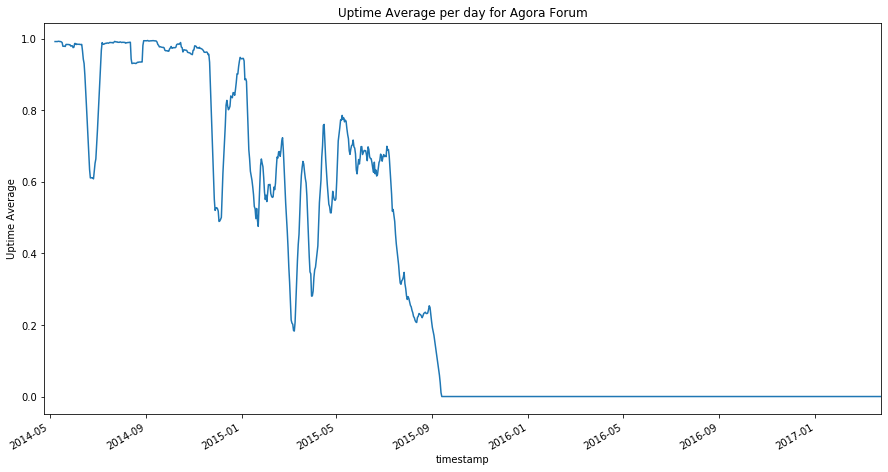

In [28]:
plotUptime(forum_subdf1['siteup'], 'Uptime Average per day for Agora Forum')

> We observe that the uptime average is very fluctuant over the time for both Agora and Agora Forum. It made the webscrapping quite difficult to do, we have to expect a lot of missing data. Now let's take a look just before and after the Onymous operation: 

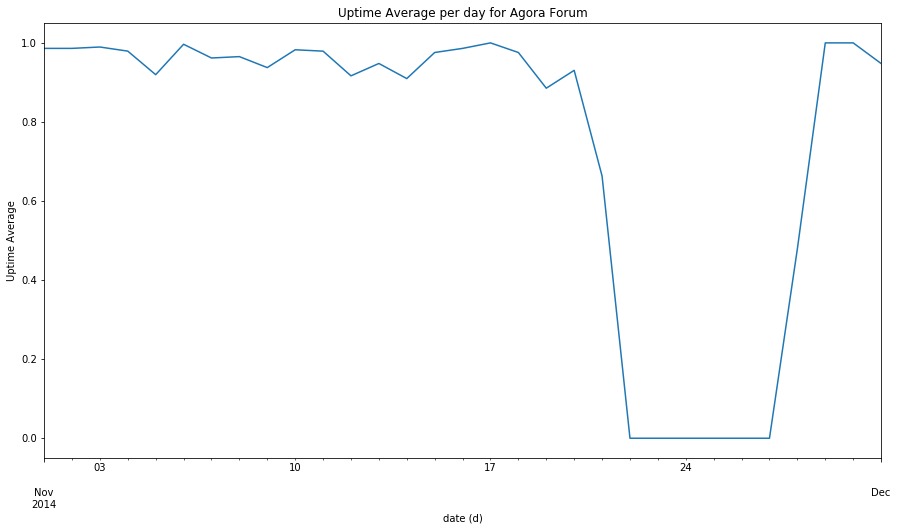

In [31]:
date_range = pd.date_range(start='2014-11-01', end='2014-12-01', freq='D')
plotUptime(forum_subdf1['siteup'][date_range], 'Uptime Average per day for Agora Forum', win=1)

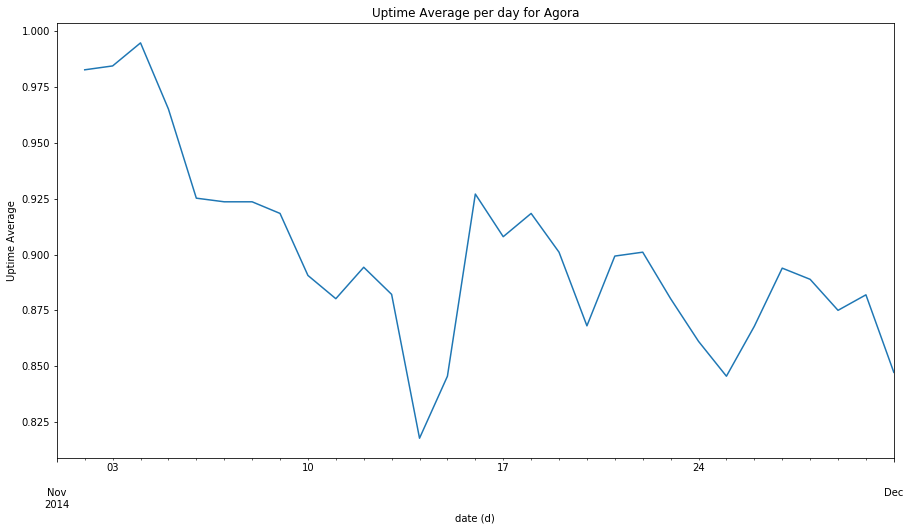

In [36]:
plotUptime(agora_subdf1['siteup'][date_range], 'Uptime Average per day for Agora', win=2)

Take a look at the period of Operation Onymous and see that there is a fall in the uptime average shortly after both for market and forum, but not at the same time. We also observe that shortly after the drop, the uptime average is back to normal for the forum and it has increased for the market but it tends to slow down.

# 2) Forum Analysis

In [38]:
forumDF = pd.read_csv('saved_gen_df/nPages_nTopicest_nSample_perDayAndBoard.csv')
filtered_df = pd.read_csv('saved_gen_df/forum_filtered_df.csv')
forum_stats = pd.read_csv('saved_gen_df/forum_stats_df.csv')

FileNotFoundError: [Errno 2] File b'saved_gen_df/forum_filtered_df.csv' does not exist: b'saved_gen_df/forum_filtered_df.csv'

In [120]:
#forum_stats.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'],inplace=True)
filtered_df.drop(columns=['tokens'],inplace=True)

filtered_df['board'] = filtered_df['board'].astype(str)

In [121]:
def word_extract(x):
    words = []
    # Loop over the words in the title
    for i in x:
        words.append(i)

    return words

In [122]:
filtered_df.head()

date                                       board        author  \
0  2014-01-02  ('General Category', 'General Discussion')      Scarface   
1  2014-01-02  ('General Category', 'General Discussion')     Manlyness   
2  2014-01-02  ('General Category', 'General Discussion')       maligan   
3  2014-01-02  ('General Category', 'General Discussion')  Mangling2012   
4  2014-01-02  ('General Category', 'General Discussion')       stannis   

   nReplies  nViews                        lastPost            clean_title  \
0         8     106  December 23, 2013, 07:08:51 am        become  vendor    
1         1      31  December 23, 2013, 04:35:33 am          buyer account   
2         2      49  December 23, 2013, 04:23:34 am              sign        
3         0      17  December 23, 2013, 04:03:37 am  hello hello  good       
4         3      89  December 23, 2013, 02:51:52 am    marketplace invite    

              tokens_filtered  
0         ['becom', 'vendor']  
1        ['buyer', 'account']  
2                    ['sign']  
3  ['hello', 'hello', 'good']  
4     ['marketplac', 'invit']

In [123]:
#Selection of boards to look into
boards_bf = np.array(["('General Category', 'Vendor Discussion')",
       "('General Category', 'Newbie Section ')",
       "('General Category', 'Referral Links')",
       "('General Category', 'Security Discussion')"])

In [124]:
# Sub-set for the 4 months preceeding the Onymous event
subdf_bef = filtered_df[(filtered_df['date'] >= '2014-07-05') & (filtered_df['date'] <= '2014-11-06')
                       & (filtered_df['board'].isin(boards_bf))]
# Sub-set for the month following the Onymous event
subdf_af = filtered_df[(filtered_df['date'] >= '2014-11-07') & (filtered_df['date'] <= '2014-12-07')
                      & (filtered_df['board'].isin(boards_bf))]

In [ ]:
all_words_bf = sum(word_extract(subdf_bef['tokens_filtered']), [])
all_words_af = sum(word_extract(subdf_af['tokens_filtered']), [])

In [ ]:
a = nltk.FreqDist(all_words_bf)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 25) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d[5:], x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [ ]:
a = nltk.FreqDist(all_words_af)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 25)
print(d[3:])
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d[5:], x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Forum activity

In addition to the faulty sampling itself, the global activity on the forum seems to be quite eventful, considering several significant content but mostly a high production rate.

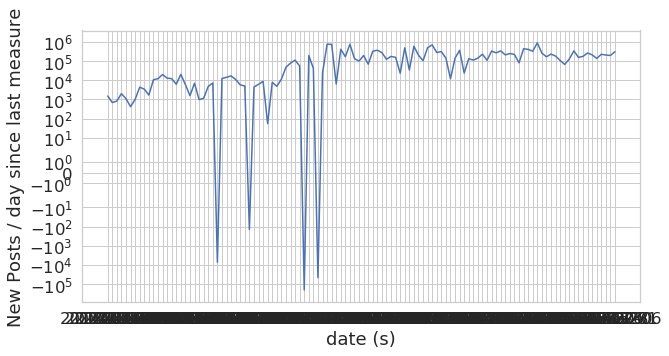

In [126]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Posts / day since last measure')
ax1.plot(forum_stats['date'], forum_stats['new_posts'])
ax1.tick_params(axis='y')

plt.yscale('symlog')
plt.show()

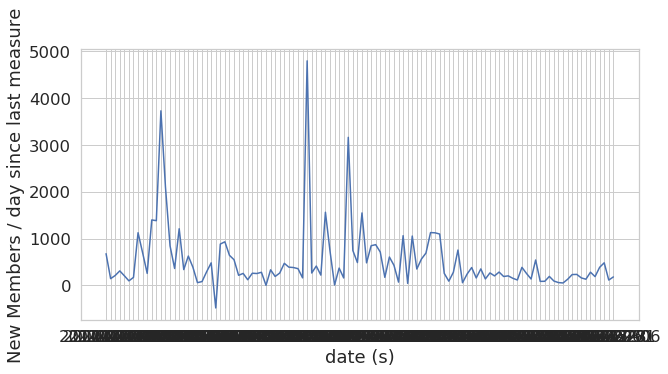

In [127]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Members / day since last measure')
ax1.plot(forum_stats['date'], forum_stats['new_members'])
ax1.tick_params(axis='y')

plt.show()

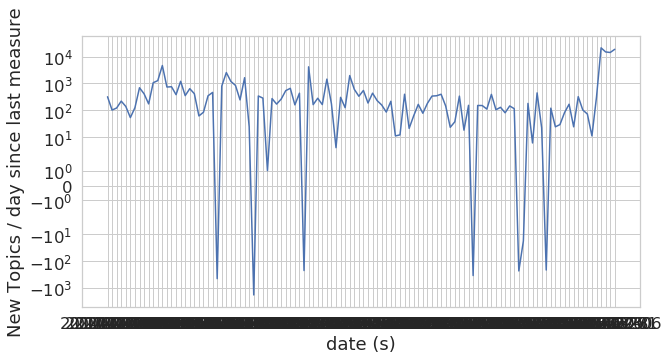

In [128]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Topics / day since last measure')
ax1.plot(forum_stats['date'], forum_stats['new_topics'])
plt.yscale('symlog')

plt.show()

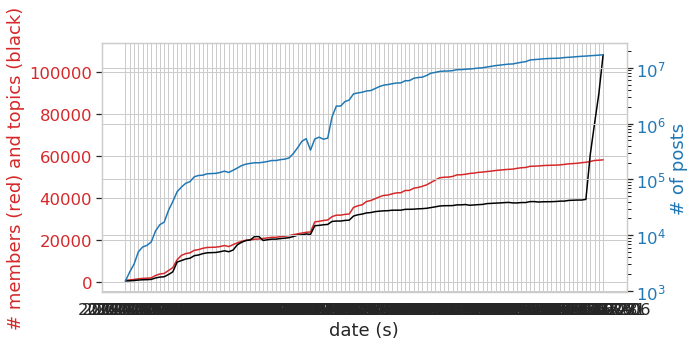

In [129]:
# Plot the number of members (red), of topics (black) and of posts (blue) over time
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('date (s)')
ax1.set_ylabel('# members (red) and topics (black)', color=color)
ax1.plot(forum_stats['date'], forum_stats['members'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(forum_stats['date'], forum_stats['topics'], color='black')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# of posts', color=color)  # we already handled the x-label with ax1
ax2.plot(forum_stats['date'], forum_stats['posts'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yscale('log')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [130]:
forum_stats[forum_stats['new_posts'] < 0]
# Show that posts were removed on those particular days

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  members  \
24          24            24              24                24    16716   
31          31            31              31                31    20317   
43          43            43              43                43    23664   
46          46            46              46                46    29143   

     posts  topics  nOnline        date  new_posts  days_elapsed  new_members  \
24  132894   14246        5  2014-06-10    -7243.0           1.0       -482.0   
31  198093   21485        5  2014-08-02     -142.0           3.0        121.0   
43  334265   22495        5  2014-09-28  -201673.0           2.0        161.0   
46  523840   27080        5  2014-11-21   -46268.0           2.0        414.0   

    new_topics  
24      -460.0  
31        24.0  
43      -229.0  
46       279.0

In [131]:
forum_stats[forum_stats['new_members'] < 0]
# Show that members were removed this days precisely

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  members  \
24          24            24              24                24    16716   

     posts  topics  nOnline        date  new_posts  days_elapsed  new_members  \
24  132894   14246        5  2014-06-10    -7243.0           1.0       -482.0   

    new_topics  
24      -460.0

In [132]:
forum_stats[forum_stats['new_topics'] < 0]
# Show that topics were removed on those particular days

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  members  \
24          24            24              24                24    16716   
32          32            32              32                32    20577   
43          43            43              43                43    23664   
80          80            80              80                80    51523   
90          90            90              90                90    53589   
91          91            91              91                91    53975   
96          96            96              96                96    55084   

       posts  topics  nOnline        date  new_posts  days_elapsed  \
24    132894   14246        5  2014-06-10    -7243.0           1.0   
32    202565   19623        5  2014-08-05     4472.0           3.0   
43    334265   22495        5  2014-09-28  -201673.0           2.0   
80   9510546   36372        5  2015-04-14   112282.0           1.0   
90  11693038   37503        5  2015-05-10    81219.0           4.0   
91  12132780   37485        5  2015-05-11   439742.0           1.0   
96  14186943   37915        5  2015-05-29   167278.0           1.0   

    new_members  new_topics  
24       -482.0      -460.0  
32        260.0     -1862.0  
43        161.0      -229.0  
80        382.0      -352.0  
90        116.0      -237.0  
91        386.0       -18.0  
96         88.0      -219.0

### Sample vs Estimated Number of Topics Visualization

In [133]:
px.scatter(forumDF, x="nTopics_est", y="nSample", animation_frame="date", animation_group="board",
           size='nPages', size_max=55, color="board", hover_name="board",
          range_x=[1, 30000], range_y=[1,30000], log_x=True, log_y=True)

In the map visible[here](https://github.com/ADA-2019/Project/tree/master/scripts/file.html) we can see that the number of sampled topics is always very low compared to the actual number. However, given that the limited sampled topics are generally the most recent ones, there still could be some insight to gain there.

# 3) Market Analysis

## 3.1) Data Enrichment

In [134]:
price_df = pd.read_csv('../saved_gen_df/prices_and_stuff.csv')
price_df = price_df.drop(columns=['mean', 'std', 'min', '25%', '75%'])

In [135]:
# From the Grams archive, listings were parsed and we only kept the sampling date and the number of listing
#             for every country
price_df

filename                 ship_from  count       50%       max
0      2014-06-09                 Argentina   18.0  0.000000  0.000000
1      2014-06-09                 Australia  592.0  0.000000  0.000000
2      2014-06-09                   Austria   11.0  0.000000  0.000000
3      2014-06-09                   Belgium   66.0  0.000000  0.000000
4      2014-06-09                    Brazil    2.0  0.000000  0.000000
...           ...                       ...    ...       ...       ...
14514  2015-07-12                  bluerave  137.0  0.003000  0.150000
14515  2015-07-12            United Kingdom    4.0  0.249186  0.614932
14516  2015-07-12  United States of America    2.0  0.282305  0.282305
14517  2015-07-12                     world    1.0  0.090443  0.090443
14518  2015-07-12                 worldwide    3.0  0.033766  0.037484

[14519 rows x 5 columns]

In [136]:
# Get world map
world = geopandas.read_file(
    geoplot.datasets.get_path('world')
)
sf = shp.Reader('../data/ne_50m_admin_0_countries.shp')
world_df = read_shapefile(sf)

In [137]:
# Merge using the country names as index
world_df = world_df[['NAME', 'CONTINENT']]
world_df.rename(columns={'NAME':'name'}, inplace=True)
world_df = pd.merge(world, world_df, how='inner')

In [138]:
world_df['count'] = 0
world_df['continent_count'] = 0

In [139]:
# Create map filling count for a given sample 
DATE = "2015-07-12"
world_df['count'] = world_df['name'].apply((lambda x : fillCountryCount(x,DATE)))
world_df['continent_count'] = world_df['CONTINENT'].apply((lambda y : fillContinentCount(y, DATE)))

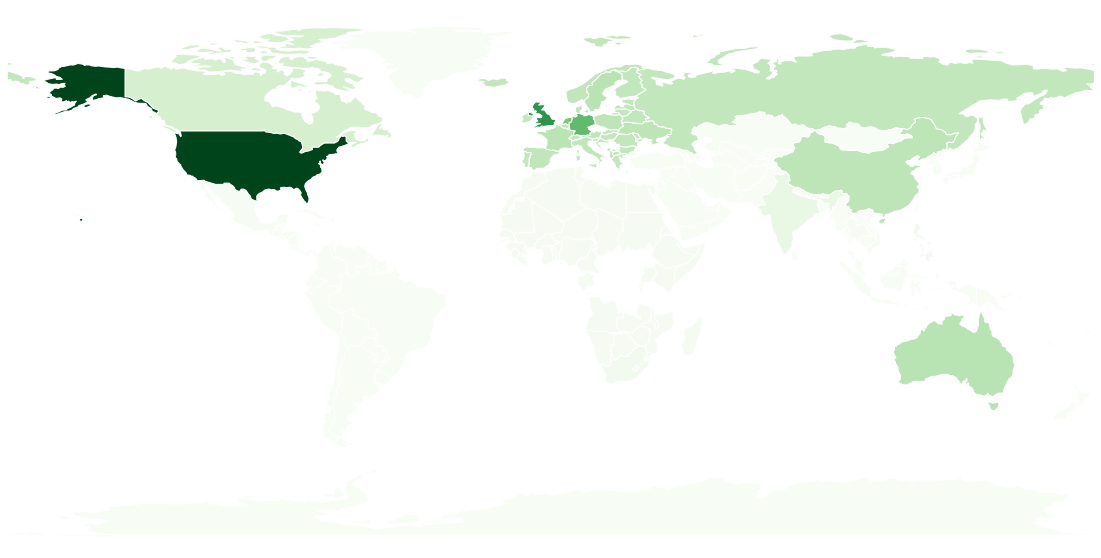

In [140]:
geoplot.choropleth(world_df, hue=world_df['count']+world_df['continent_count'],cmap='Greens', figsize=(20, 10));

We clearly can see that some areas are more populated than others, this angle could then possibly provide insightful information when studying the market.

## 3.3) Vendors Insight

In [39]:
vendorsDF = pd.read_csv('saved_gen_df/vendorsDF_lastSeen_country_df.csv').drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])

FileNotFoundError: [Errno 2] File b'saved_gen_df/vendorsDF_lastSeen_country_df.csv' does not exist: b'saved_gen_df/vendorsDF_lastSeen_country_df.csv'

In [142]:
vendorsDF.head(10)

name  rating    lastSeen  #products    #Deals parsingDate  \
0      littlegoblin   4.920  2014-09-19       14.0   150~200  2014-09-20   
1    Rebel_Alliance   4.990  2014-09-19        7.0   300~500  2014-09-20   
2     ThePartyDepot   5.000  2014-09-19        3.0    70~100  2014-09-20   
3          cossacks   4.990  2014-09-19        7.0   300~500  2014-09-20   
4        checkpoint   4.840  2014-09-19       31.0     55~70  2014-09-20   
5    GermanTerminal   4.994  2014-09-19       37.0  500~1000  2014-09-20   
6               AGP   4.910  2014-09-18        2.0    70~100  2014-09-20   
7       Top_Gear_UK   4.830  2014-09-19       21.0  500~1000  2014-09-20   
8  onefamilyonelove     NaN  2014-09-19        4.0         0  2014-09-20   
9            xinhai   4.974  2014-09-20       10.0     1000+  2014-09-20   

     country  
0         EU  
1     Canada  
2  Australia  
3         UK  
4    Belgium  
5    Germany  
6  Australia  
7         UK  
8        USA  
9        USA

We remove the date were the number of vendors is inferior to 150 since they are obviously consequence of a technical problem


In [143]:
nbVendorbyDate = vendorsDF[['parsingDate', 'name']].groupby(['parsingDate']).agg([ 'count'])
nbVendorbyDate = nbVendorbyDate[nbVendorbyDate[('name', 'count')] >150]

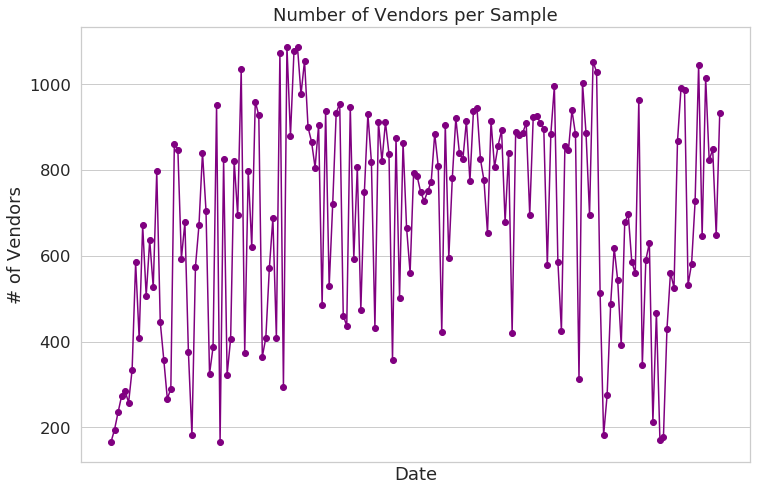

In [144]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(nbVendorbyDate.index,
        nbVendorbyDate[('name', 'count')],
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of Vendors",
       title="Number of Vendors per Sample")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()

Clearly, we see that this measure is not exploitable like this, vendor data will need to be enriched to obtain a significant representation of their population.

### Number of listing per Vendor

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24963f4ef0>]],
      dtype=object)

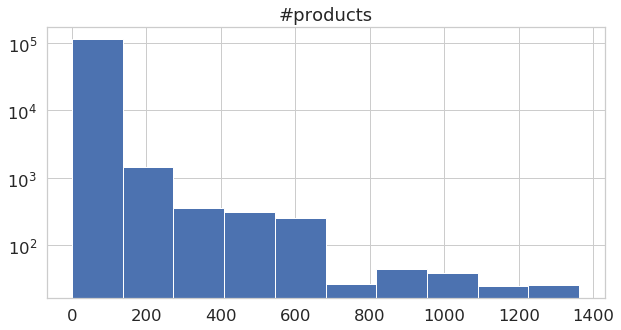

In [145]:
vendorsDF.hist(column='#products',log=True,figsize=(10,5))

This plot shows the huge variation inn the number of products sold by vendors. That means studying this feature might be insightful in order to understand the state of the market and the vendor population.

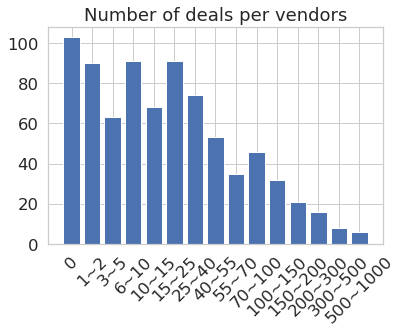

In [146]:
sortedStats = createStatsAboutNumbOfDeals(Counter(vendors['#Deals']))
plt.bar(sortedStats.keys(),sortedStats.values());
plt.xticks(rotation=45);
plt.title('Number of deals per vendors');

## 3.4) Listing insight

In this section, we will try to understand all the products listed in agora-market that we managed to retrieve.

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.option("header", "true").csv("data/cat_csv/*.csv")
df.count()

2805212

So in total we have 2805212 products, we selected the following features: 

In [5]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- from: string (nullable = true)
 |-- to: string (nullable = true)
 |-- vendor: string (nullable = true)
 |-- cat_hash: string (nullable = true)
 |-- cat: string (nullable = true)
 |-- date: string (nullable = true)



### Cleaning
> After some analysis, we cleaned the data as follow: 

In [3]:
def processCountries(country):
    # Remove html tags
    cleanr = re.compile('<.*?>')
    cleanText = str(re.sub(cleanr, '', str(country)))
    
    # Remove spaces
    cleanText = cleanText.strip(' ')
    
    # Remove ""
    cleanText = cleanText.strip('"')
    
    # Split for each country
    cleanText = re.split("&|,|/", cleanText)
    
    # Top Names reformat
    cleanText = [re.sub(r'^(eu|europeanunion|euonly|europeuniononly|onlytoeurope|europeancountries|westerneurope|ukandeuonly|franceandeu)$', r'europe', w) for w in cleanText]
    cleanText = [re.sub(r'^(everywhere|world|international|anywhere|worlwide|worldwideonrequest|ww|wordwide|global|worldwideinternational|wideworld|all|worldwidepriortracking|wordlwide|worldwideprior|worldwideprior|internationalworldwide|universe|everywhereworldwideanydestination|wolrdwide|wwshipping|freeworldwide|universal|woldwide|worldwideincludingaustralia|worldwidepriorthefastest|internationally)$', r'worldwide', w) for w in cleanText]
    cleanText = [re.sub(r'^(usaonly|unitedstates|us|unitedstatesofamerica|usonly|unitedstatesonly)$', r'usa', w) for w in cleanText]
    cleanText = [re.sub(r'^(unitedkingdom|ukonly)$', r'uk', w) for w in cleanText]
    return cleanText

udf_func_C = udf(processCountries, ArrayType(StringType()))

def processCatHashs(cat_hash):
    # Remove html end of files
    cleanr = re.compile('.\d*.html')
    cleanText = str(re.sub(cleanr, '', str(cat_hash)))
    return cleanText

udf_func_H = udf(processCatHashs, StringType())

# Remove rows without a valid date, error during parsing, file not complete
df = df.filter(df["date"].rlike("\d\d\d\d-\d\d-\d\d"))

# Remove rows without a price or not decimal, 642 in total, mainly due to error during parsing.
df = df.filter("CAST(price AS DECIMAL) is not null")

# Remove the rows where name is null, all the columns are usually null in this case, (6 rows)
df = df.filter("name is not null")

# Lowercase and process the countries
df=df.withColumn("to", lower(col("to")))
df=df.withColumn("to", udf_func_C(col("to")))

# Lowercase and process the countries
df=df.withColumn("from", lower(col("from")))
df=df.withColumn("from", udf_func_C(col("from")))

# Process the hashs
df=df.withColumn("cat_hash", udf_func_H(col("cat_hash")))

### Number of products availables on the market
> Once our data cleaned, we wanted to know if the number of listing per day parsed was consistent

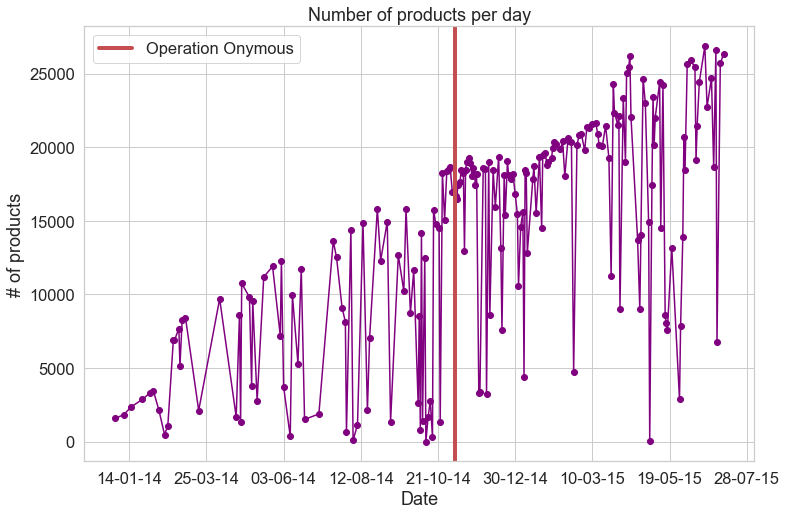

In [4]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

pdDF = df.groupby("date").agg(count("date").alias("numberOfProductsParsed")).toPandas()
pdDF = pdDF[pdDF['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
pdDF['date'] = pd.to_datetime(pdDF['date'],infer_datetime_format=True) 
pdDF = pdDF.sort_values(by='date', ascending=True, na_position='first')

def plotNDate(x, y, interval, title, y_label):
    # Prettier plotting with seaborn
    sns.set(font_scale=1.5, style="whitegrid")

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(x,
            y,
            '-o',
            color='purple')
    ax.set(xlabel="Date", ylabel=y_label,
           title=title)
    
    plt.axvline(linewidth=4, color='r', x="2014-11-05", label="Operation Onymous")

    # Format the x axis
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

    # Ensure ticks fall once every other week (interval=2) 
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interval))
    plt.legend()
    plt.show()
plotNDate(pdDF['date'],pdDF['numberOfProductsParsed'], 10,"Number of products per day", "# of products")

> We can see here that we have a lot of missing values, the number of products increase linearly but it drop a lot unpredictably, in order to get the correct number of products per date, we parsed the main page of Agora, in which there is an approximation by category of the number of product

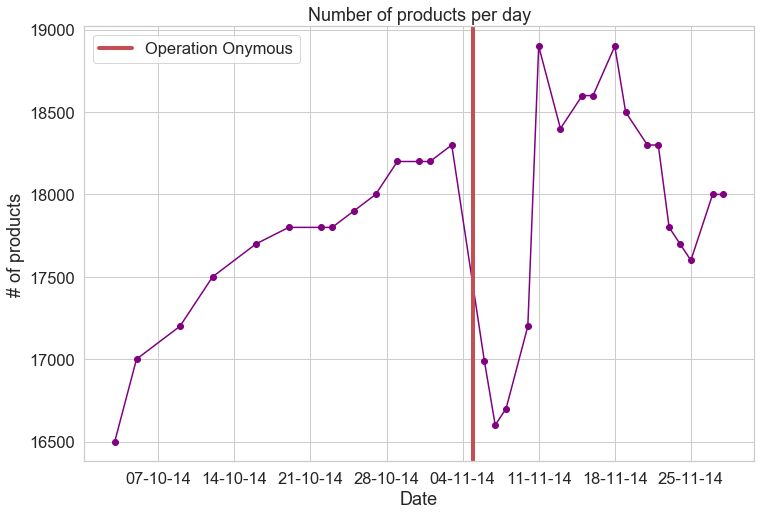

In [5]:
import scripts.nbProductsParse as t
products_per_day = t.directoryToDF("data/index/")
products_per_day['date'] = pd.to_datetime(products_per_day['date'],infer_datetime_format=True) 
products_per_day = products_per_day.sort_values(by='date', ascending=True, na_position='first')
products_per_day_onymous = products_per_day[products_per_day['date']>'2014-10-01']
products_per_day_onymous = products_per_day_onymous[products_per_day_onymous['date']<'2014-12-01']

plotNDate(products_per_day_onymous['date'],products_per_day_onymous['numberOfProducts'], 1,"Number of products per day", "# of products")


> We can see here that if we pick the number of products obtained in the main page of agora, the result seems more predictable than before, it could be a solution to our missing data problem, we just need to compare this values to the ones previously obtained with our list of all products per year and keep only the date in which we have a satisfactory amount of data compare to the numbers shown on the agora main page. 
> Furthemore, we observe a decrease in the number of products just during the onymous operation

In [6]:
merged_inner = pd.merge(left=pdDF,right=products_per_day, left_on='date', right_on='date')
merged_inner['ratio_parsed_approx'] = (100*merged_inner['numberOfProductsParsed']/merged_inner['numberOfProducts'])
merged_inner = merged_inner[merged_inner['ratio_parsed_approx'] > 100]
merged_inner['date'] = pd.to_datetime(merged_inner['date'],infer_datetime_format=True) 
merged_inner.count()

date                      61
numberOfProductsParsed    61
numberOfProducts          61
ratio_parsed_approx       61
dtype: int64

In [424]:
merged_inner['date']

0     2014-01-01
1     2014-01-09
2     2014-01-16
3     2014-01-26
4     2014-02-02
5     2014-02-05
9     2014-02-23
10    2014-02-24
11    2014-02-28
13    2014-03-03
14    2014-03-06
16    2014-04-06
47    2014-08-27
64    2014-10-25
66    2014-10-29
67    2014-10-31
68    2014-11-01
72    2014-11-08
73    2014-11-10
77    2014-11-16
78    2014-11-18
79    2014-11-19
81    2014-11-22
82    2014-11-23
84    2014-11-25
87    2014-12-01
88    2014-12-03
90    2014-12-06
94    2014-12-15
99    2014-12-23
100   2014-12-24
101   2014-12-26
102   2014-12-28
109   2015-01-08
113   2015-01-16
115   2015-01-21
117   2015-01-24
118   2015-01-26
120   2015-01-29
122   2015-02-02
123   2015-02-03
124   2015-02-05
126   2015-02-11
128   2015-02-16
133   2015-02-26
134   2015-02-28
136   2015-03-05
137   2015-03-07
138   2015-03-10
139   2015-03-13
140   2015-03-15
146   2015-03-29
147   2015-03-30
148   2015-04-02
153   2015-04-10
154   2015-04-12
155   2015-04-13
160   2015-04-25
179   2015-06-

> The number of products obtained on the main page of agora is approximatif, rounded to the lower hundred, so we can be pretty confident that when we parsed at least the same amount of product than shown on the main page of agora for a specific date, the products for this date are almost complete, if we keep only this dates, we obtain the following graph

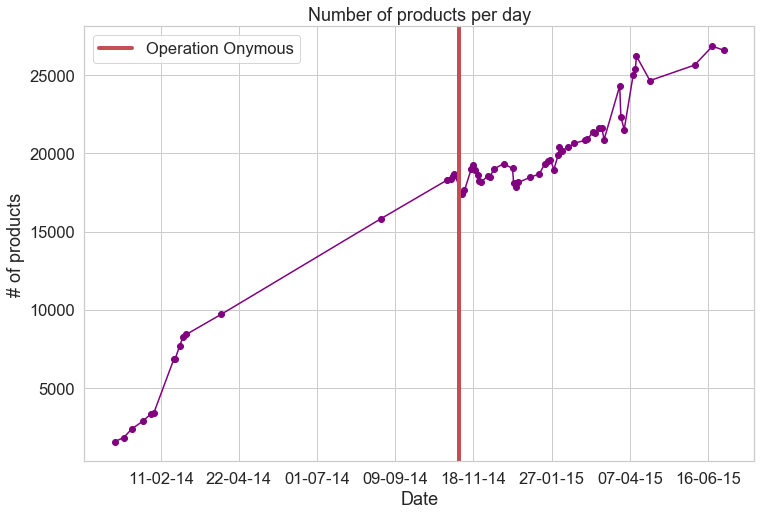

In [13]:
plotNDate(merged_inner['date'],merged_inner['numberOfProductsParsed'], 10,"Number of products per day", "# of products")


In [381]:
merged_inner['numberOfProductsParsed'].values

array([ 1566,  1823,  2368,  2867,  3319,  3421,  6876,  6869,  7676,
        8258,  8423,  9697, 15814, 18278, 18379, 18539, 18676, 17412,
       17636, 18988, 19234, 18926, 18589, 18203, 18172, 18570, 18509,
       18989, 19343, 19038, 18093, 17849, 18143, 18471, 18690, 19345,
       19484, 19595, 18963, 19929, 20379, 20182, 20397, 20645, 20842,
       20899, 21361, 21318, 21600, 21613, 20884, 24324, 22330, 21529,
       25009, 25426, 26222, 24659, 25650, 26860, 26602])

> Althought more than 3/4 of the data we parsed is highly incomplete, the graph above tells us that during the period of Onymous, the data is often complete, this quite helpful for us. Now that we can trust our data, let's take a look on which items was deleted between 2014-11-01 and 2014-11-08, the date before and after Operaration Onymous in which we have datas:

### Active vendors

In [112]:
vendors = df.groupby("date").agg(countDistinct('vendor').alias("numberOfVendor")).toPandas()
vendors['date'] = pd.to_datetime(vendors['date'],infer_datetime_format=True) 
vendors = vendors.sort_values(by='date', ascending=True, na_position='first')
vendors.set_index('date', inplace=True)

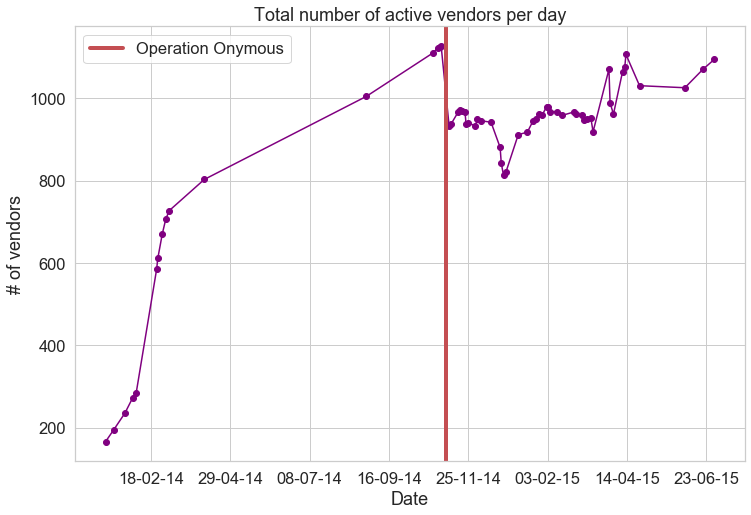

In [114]:
vendors_filtered = vendors.loc[merged_inner['date']]
vendors_filtered = vendors_filtered[vendors_filtered.index>'2014-01-01']
vendors_filtered = vendors_filtered[vendors_filtered.index<'2015-12-01']

plotNDate(vendors_filtered.index,vendors_filtered['numberOfVendor'], 10,"Total number of active vendors per day", "# of vendors")


> We can see here that 311 vendors was either removed or removed their products just during the operation Onymous
Let's see at a larger scale how the total number of active vendors (those who have products to sell) fluctuate: 

> We can see here that there is a big hole in the number of active vendors just after Operation Onymous, but it seems to recover to it's initial value 4 months after the operation, let's see if those missing vendors quit definitevely and if the upside trend is due to new vendors on the platform : 

### New vendors

In [75]:
#print(diff['vendor'].unique())
posts_per_vendors_date = df.groupby("date", "vendor").agg(countDistinct('name').alias("numberOfPosts")).toPandas()
posts_per_vendors_date['date'] = pd.to_datetime(posts_per_vendors_date['date'],infer_datetime_format=True) 
posts_per_vendors_date = posts_per_vendors_date.sort_values(by='date', ascending=True, na_position='first')
posts_per_vendors_date = posts_per_vendors_date.set_index('date')
posts_per_vendors_date = posts_per_vendors_date.loc[merged_inner['date']]
posts_per_vendors_date.head()

vendor  numberOfPosts
date                                  
2014-01-01  Synthiotics              4
2014-01-01      RedBull              4
2014-01-01    theanchor              1
2014-01-01     weed4you              2
2014-01-01   FakeMarket             28

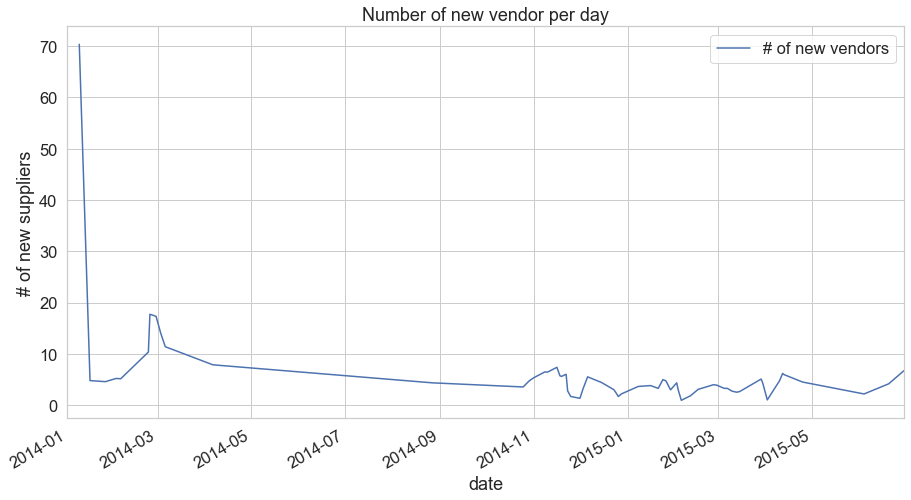

In [353]:
new_vendors = pd.DataFrame()
new_vendors['count'] = posts_per_vendors_date[~posts_per_vendors_date.duplicated(subset="vendor", keep='first')]['vendor'].groupby('date').count()

new_vendors.reset_index(level=0, inplace=True)
new_vendors['difference'] = new_vendors['date'].diff().fillna(0)
new_vendors['# of new vendors'] = new_vendors['count']/(new_vendors['difference'].dt.days + 1)
new_vendors = new_vendors[['date', '# of new vendors']]
new_vendors.set_index('date', inplace=True)

fig, ax1 = plt.subplots( figsize=(15,8))
ax1.set_ylabel('# of new suppliers')
new_vendors.rolling(window=2).mean().plot(
      kind='line', use_index=True, ax=ax1)
ax1.tick_params(axis='y')
plt.title("Number of new vendor per day")
plt.show()



### Big vs Small suppliers

In [413]:
before = df.filter(df.date < "2014-11-01").select('vendor').distinct().toPandas()
after = df.filter(df.date > "2014-11-08").select('vendor').distinct().toPandas()

vendors_that_stayed = before[before['vendor'].isin(after['vendor'])]
vendors_that_retired = before[~before['vendor'].isin(after['vendor'])]
vendors_that_stayed = posts_per_vendors_date[posts_per_vendors_date['vendor'].isin(vendors_that_stayed.values.squeeze())].groupby('date').mean()
vendors_that_retired = posts_per_vendors_date[posts_per_vendors_date['vendor'].isin(vendors_that_retired.values.squeeze())].groupby('date').mean()
all_vendors = posts_per_vendors_date.groupby('date').mean()

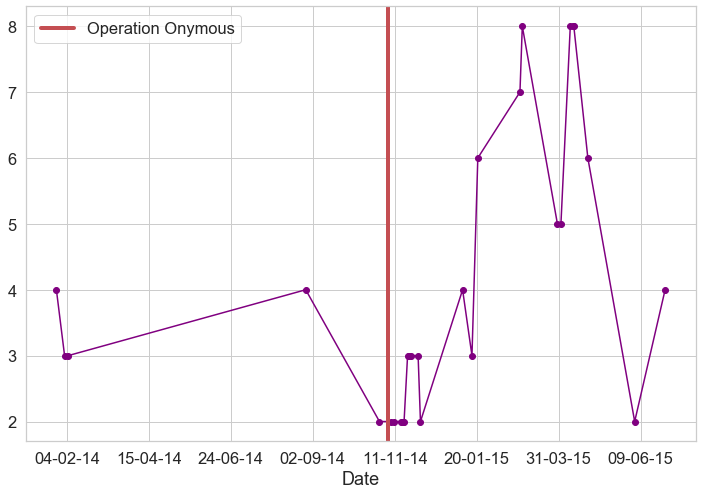

vendor  numberOfPosts
date                                 
2014-01-26  MadCorsair              4
2014-02-02  MadCorsair              3
2014-02-05  MadCorsair              3
2014-08-27  MadCorsair              4
2014-10-29  MadCorsair              2
2014-11-08  MadCorsair              2
2014-11-10  MadCorsair              2
2014-11-16  MadCorsair              2
2014-11-18  MadCorsair              2
2014-11-19  MadCorsair              2
2014-11-22  MadCorsair              3
2014-11-23  MadCorsair              3
2014-11-25  MadCorsair              3
2014-12-01  MadCorsair              3
2014-12-03  MadCorsair              2
2015-01-08  MadCorsair              4
2015-01-16  MadCorsair              3
2015-01-21  MadCorsair              6
2015-02-26  MadCorsair              7
2015-02-28  MadCorsair              8
2015-03-30  MadCorsair              5
2015-04-02  MadCorsair              5
2015-04-10  MadCorsair              8
2015-04-12  MadCorsair              8
2015-04-13  MadCorsair              8
2015-04-25  MadCorsair              6
2015-06-04  MadCorsair              2
2015-06-30  MadCorsair              4

In [83]:
test_vendor = posts_per_vendors_date[posts_per_vendors_date['vendor'].isin(["MadCorsair"])]
plotNDate(test_vendor.index,test_vendor['numberOfPosts'], 10,"", "")
test_vendor

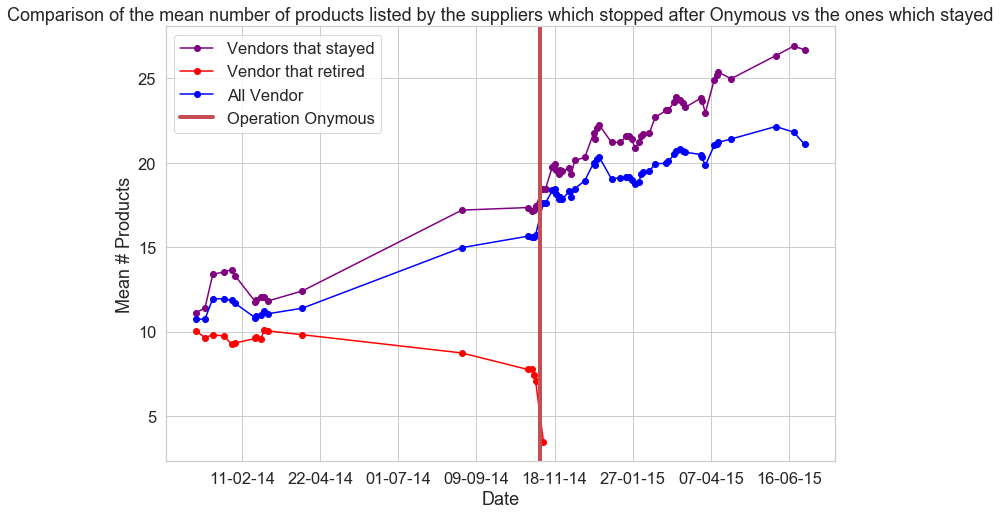

In [414]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(vendors_that_stayed.index,
        vendors_that_stayed.numberOfPosts,
        '-o',
        color='purple',
        label='Vendors that stayed')
ax.plot(vendors_that_retired.index,
        vendors_that_retired.numberOfPosts,
        '-o',
        color='red',
       label='Vendor that retired')

ax.plot(all_vendors.index,
        all_vendors.numberOfPosts,
        '-o',
        color='blue',
       label='All Vendor')

ax.set(xlabel="Date", ylabel="Mean # Products",
       title="Comparison of the mean number of products listed by the suppliers which stopped after Onymous vs the ones which stayed")

plt.axvline(linewidth=4, color='r', x="2014-11-05", label="Operation Onymous")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend()
plt.show()

### Type of products

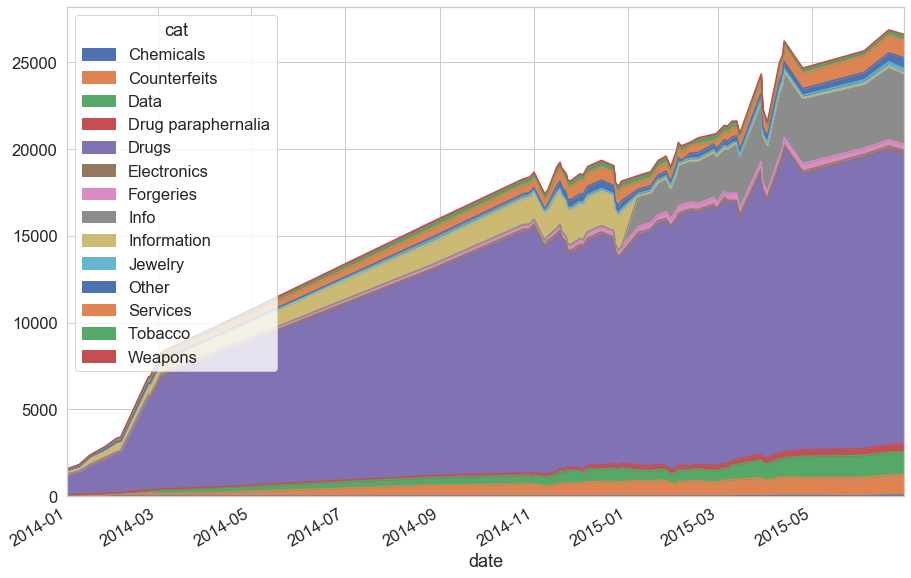

In [400]:
def processCat(cat):
    # Take only top category
    cleanr = cat.split("/")
    return cleanr[0]

udf_func_C = udf(processCat, StringType())

categories=df.withColumn("cat", udf_func_C(col("cat")))
categories = categories.select("date", "cat").groupby('date', 'cat').count().toPandas()
categories['date'] = pd.to_datetime(categories['date'],infer_datetime_format=True) 
categories_count = categories.sort_values(by='date', ascending=True, na_position='first')
categories_count = pd.pivot_table(categories_count, values='count', index='date',
                     columns=['cat'])
categories_count = categories_count.fillna(0)
categories_count.loc[merged_inner['date']].plot.area(figsize=(15,10))

## Countries Analysis

The operation Onymous involved 17 countries, in the further analysis we will focus on the importation/exportation toward this countries: 
   - Bulgaria
   - Czech Republic 
   - Finland 
   - France
   - Germany
   - Hungary
   - Ireland
   - Latvia
   - Lithuania
   - Luxembourg
   - Netherlands 
   - Romania
   - Spain 
   - Sweden
   - Switzerland
   - United Kingdom
   - USA

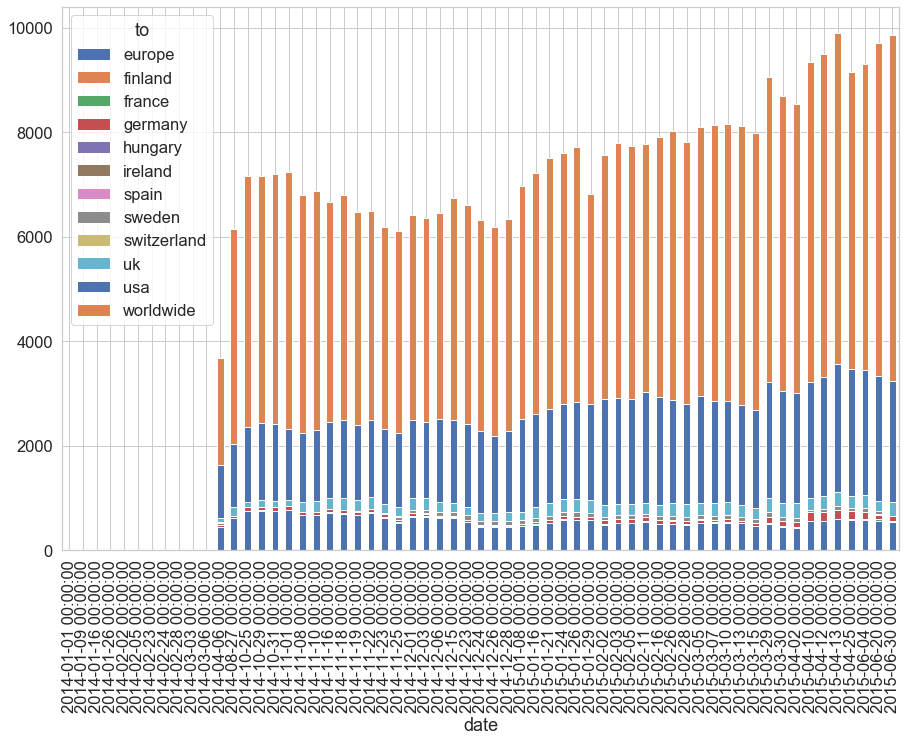

In [430]:
pd.set_option('display.max_rows', 200)
countries = ['worldwide','bulgaria', 'usa', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
filtered_tos=df.withColumn("cat", udf_func_C(col("cat"))).filter(col('cat').isin("Drugs"))
filtered_tos = df.select('date', pyspark.sql.functions.explode(col("to")).alias("to")).groupby('date', 'to').count().filter(col('to').isin(countries)).toPandas()
filtered_tos['date'] = pd.to_datetime(filtered_tos['date'],infer_datetime_format=True) 
filtered_tos = filtered_tos.sort_values(by='date', ascending=True, na_position='first')
filtered_tos = pd.pivot_table(filtered_tos, values='count', index='date',
                     columns=['to'])

#Filter only consistent data
filtered_tos = filtered_tos.loc[merged_inner['date']]

# Get ratio and plot
#filtered_tos.div(filtered_tos.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(15,10))
filtered_tos[].plot.bar(stacked=True, figsize=(15,10))

In [9]:
all_countries = df.groupby("from").agg(count("from"))
all_countries.count()

274

In [80]:
import pyspark

asie = ['china', 'asia', 'india', 'hongkong', 'philippines', 'pakistan', 'thailand', 'singapore']
europe = ['france', 'uk', 'netherlands', 'europe', 'germany', 'belgium', 'sweden', 'ukraine', 'denmark', 'poland', 'italy', 'czechrepublic', 'spain', 'norway', 'austria', 'switzerland', 'ireland', 'ukandireland', 'finland', 'hungary', 'latvia' ]
america = ['usa', 'canada', 'mexico', 'argentina', 'brazil', 'colombia']
oceania = ['australia', 'newzealand']
africa = ['southafrica']
others = ['None', 'internet', 'rland', 'undeclared;)', 'agora', 'undeclared', 'bluerave']


def processCountries(country):
    if country in asie:
        country = "asia"
    elif country in europe:
        country = "europe"
    elif country in america:
        country = "america"
    elif country in oceania:
        country = "oceania"
    elif country in africa:
        country = "africa"
    elif country != "None" and country != "worldwide":
        country = "others"
    return country

udf_func_C = udf(processCountries, StringType())
confusion_matrix = df.select('date', pyspark.sql.functions.explode(col("to")).alias("to"), "from")
#confusion_matrix = confusion_matrix.filter(col('date') > "2014-11-05")
confusion_matrix = confusion_matrix.select('date', pyspark.sql.functions.explode(col("from")).alias("from"), "to")
confusion_matrix = confusion_matrix.withColumn("from", udf_func_C(col("from")))
confusion_matrix = confusion_matrix.withColumn("to", udf_func_C(col("to")))
confusion_matrix = confusion_matrix.groupby("from", "to").count()
confusion_matrix = confusion_matrix.filter(~col('from').isin("None")).filter(~col('to').isin("None"))
confusion_matrix = confusion_matrix.toPandas()


#all_countries.orderBy(desc("count(from)")).show(274, False)
confusion_matrix = pd.pivot_table(confusion_matrix, values='count', index='from',
                     columns=['to'], dropna=False, fill_value=0)

confusion_matrix['africa'] = np.zeros(7)
confusion_matrix = confusion_matrix[['africa', 'america', 'asia', 'europe', 'oceania', 'others', 'worldwide']]
wdwd = confusion_matrix['worldwide']/4
confusion_matrix['america'] += wdwd
confusion_matrix['africa'] += wdwd
confusion_matrix['asia'] += wdwd
confusion_matrix['europe'] += wdwd
confusion_matrix['oceania'] += wdwd

confusion_matrix = confusion_matrix.drop('worldwide', axis=1)
confusion_matrix = confusion_matrix.drop('worldwide')

# Get ratio 
#confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)



In [81]:
confusion_matrix.values

array([[3.4025000e+02, 3.4025000e+02, 3.4025000e+02, 3.4025000e+02,
        3.4025000e+02, 1.3200000e+02],
       [3.9022500e+04, 2.9409050e+05, 3.9023500e+04, 3.9194500e+04,
        3.9667500e+04, 1.0149000e+04],
       [2.3690250e+04, 2.4025250e+04, 2.3760250e+04, 2.3890250e+04,
        2.3690250e+04, 1.0190000e+03],
       [7.0121750e+04, 7.0587750e+04, 7.0124750e+04, 1.9745375e+05,
        7.0237750e+04, 4.8647000e+04],
       [2.4342500e+03, 2.4372500e+03, 2.4342500e+03, 2.4342500e+03,
        9.1586250e+04, 5.7720000e+03],
       [2.6189000e+04, 2.6817000e+04, 2.6189000e+04, 2.6207000e+04,
        3.0592000e+04, 1.1130000e+04]])

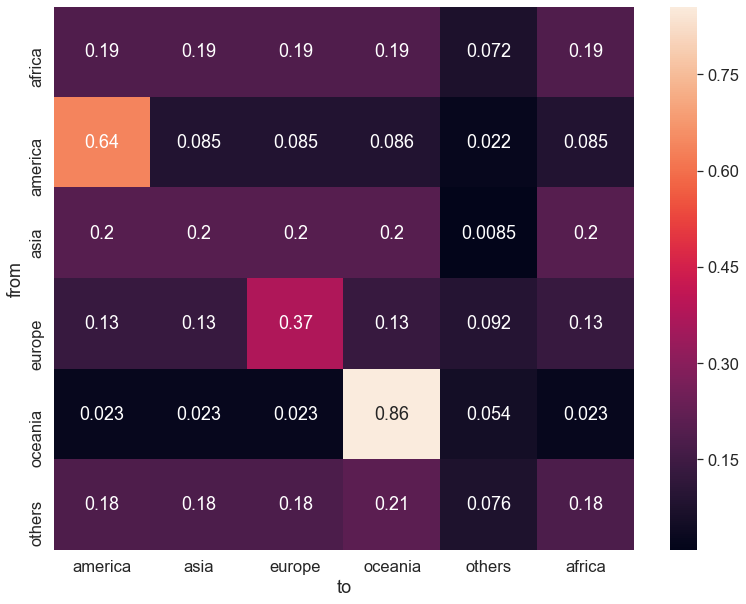

In [49]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(confusion_matrix, annot = True, ax=ax)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
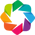

:Chord   [from,to]   (count)

In [63]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)


hv.Chord(confusion_matrix)


In [64]:
confusion_matrix

from         to   count
0     oceania    oceania   89152
1     america    oceania     645
2      europe       asia       3
3      others    oceania    4403
4     america     europe     172
5      europe     europe  127332
6   worldwide    america     164
7        asia  worldwide   94761
8        asia     others    1019
9      others     others   11130
10     others     europe      18
11  worldwide     europe     323
12  worldwide     others     514
13       asia    america     335
14  worldwide  worldwide   32490
15       asia       asia      70
16    oceania     others    5772
17    america       asia       1
18  worldwide    oceania     139
19     europe    america     466
20     africa  worldwide    1361
21       asia     europe     200
22    oceania    america       3
23    america  worldwide  156090
24     europe     others   48647
25    america    america  255068
26     europe    oceania     116
27     others    america     628
28     africa     others     132
29     europe  worldwide  280487
30    america     others   10149
31     others  worldwide  104756
32    oceania  worldwide    9737

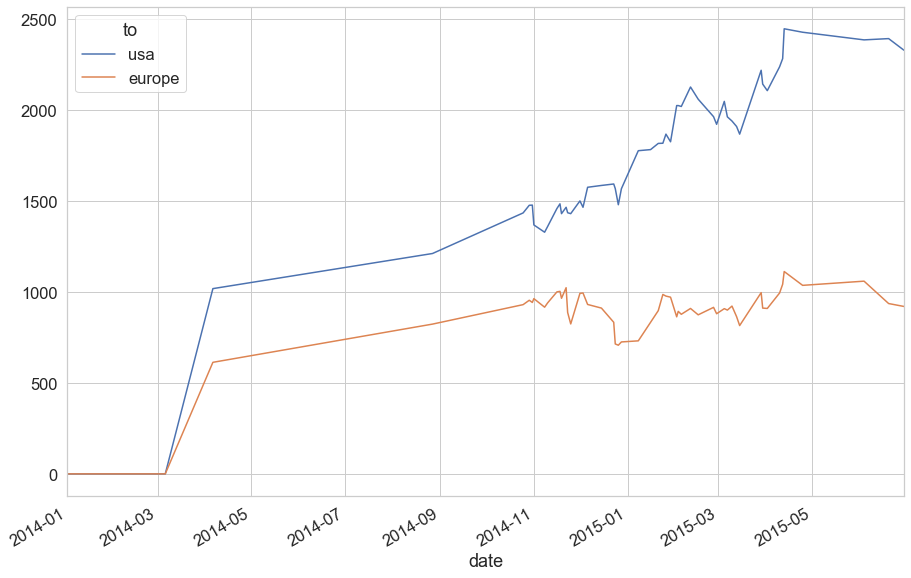

In [448]:
filtered_tos = filtered_tos.fillna(0)
test = filtered_tos[['usa', 'europe']]
test['europe'] += filtered_tos['uk']
test['europe'] += filtered_tos['germany']
test['europe'] += filtered_tos['france']
test['europe'] += filtered_tos['finland']
test['europe'] += filtered_tos['sweden']
test['europe'] += filtered_tos['hungary']
test['europe'] += filtered_tos['ireland']
test['europe'] += filtered_tos['spain']
test['europe'] += filtered_tos['switzerland']
#filtered_tos[['usa', 'uk', 'europe', 'germany', 'france', 'finland', 'sweden','hungary', 'ireland', 'spain', 'switzerland']].plot(figsize=(15,10))
test.plot(figsize=(15,10))
#test['europe']

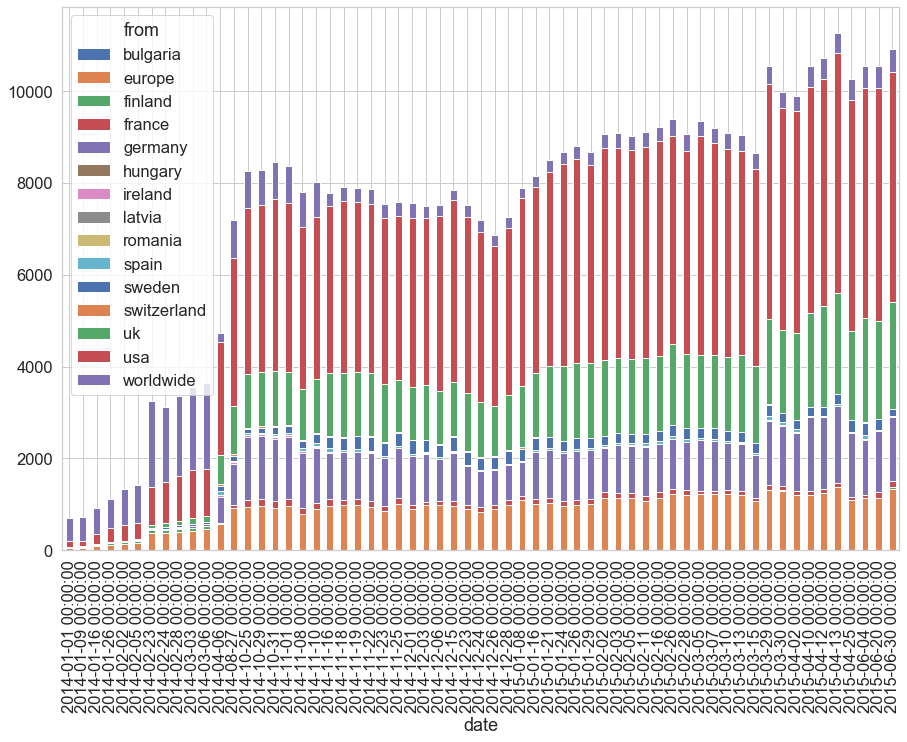

In [449]:
pd.set_option('display.max_rows', 200)
countries = ['worldwide','bulgaria', 'usa', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
filtered_tos=df.withColumn("cat", udf_func_C(col("cat"))).filter(col('cat').isin("Drugs"))
filtered_tos = df.select('date', pyspark.sql.functions.explode(col("from")).alias("from")).groupby('date', 'from').count().filter(col('from').isin(countries)).toPandas()
filtered_tos['date'] = pd.to_datetime(filtered_tos['date'],infer_datetime_format=True) 
filtered_tos = filtered_tos.sort_values(by='date', ascending=True, na_position='first')
filtered_tos = pd.pivot_table(filtered_tos, values='count', index='date',
                     columns=['from'])

#Filter only consistent data
filtered_tos = filtered_tos.loc[merged_inner['date']]

# Get ratio and plot
#filtered_tos.div(filtered_tos.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(15,10))
filtered_tos.plot.bar(stacked=True, figsize=(15,10))

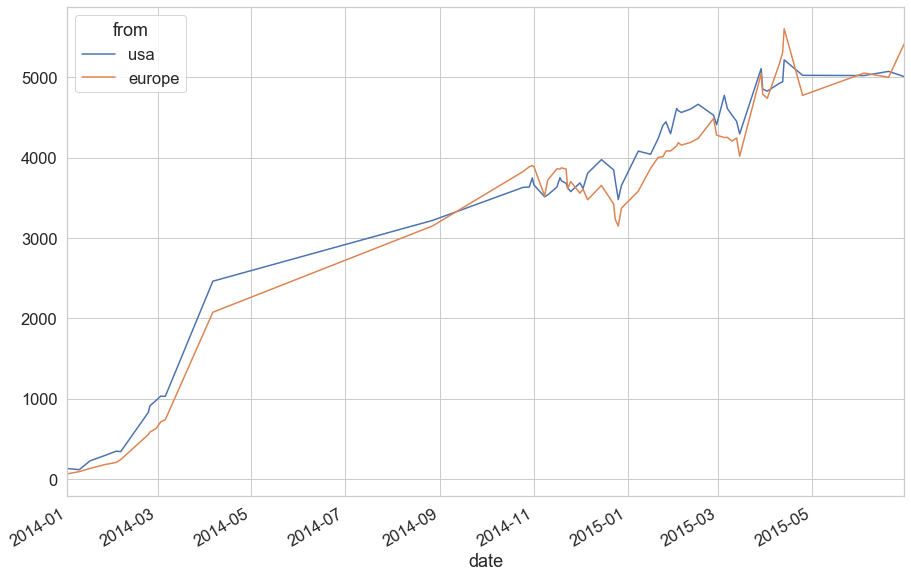

In [450]:
filtered_tos = filtered_tos.fillna(0)
test = filtered_tos[['usa', 'europe']]
test['europe'] += filtered_tos['uk']
test['europe'] += filtered_tos['germany']
test['europe'] += filtered_tos['france']
test['europe'] += filtered_tos['finland']
test['europe'] += filtered_tos['sweden']
test['europe'] += filtered_tos['hungary']
test['europe'] += filtered_tos['ireland']
test['europe'] += filtered_tos['spain']
test['europe'] += filtered_tos['switzerland']
#filtered_tos[['usa', 'uk', 'europe', 'germany', 'france', 'finland', 'sweden','hungary', 'ireland', 'spain', 'switzerland']].plot(figsize=(15,10))
test.plot(figsize=(15,10))

In [9]:
date = merged_inner['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
countries = ['worldwide','bulgaria', 'usa', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']

test = df.select('date', 'name', 'cat', "from", pyspark.sql.functions.explode(col("to")).alias("to")).filter(col('to').isin(countries))
test = test.select('date', 'name', 'cat', "to", pyspark.sql.functions.explode(col("from")).alias("from")).filter(col('from').isin(countries))
test = test.filter(col('date').isin(date.tolist()))
test.count()
#test = test.toPandas()
#test = test.loc[merged_inner['date']]
#test.head()

243850

In [11]:
test = test.toPandas()
test.head()

date                                               name  \
0  2015-06-20                                10x K2 from Nirvana   
1  2015-06-20  4 Pack Tiresias Mist Natural Feminized Seeds S...   
2  2015-06-20  5 x Auto Seeds Fast Growing Ready In 3 Months ...   
3  2015-06-20     10x Belladonna Quality Seeds by Paradise Seeds   
4  2015-06-20  5 Autoflowering Cannabis Seeds Fast Growing Re...   

                    cat         to     from  
0  Drugs/Cannabis/Seeds     europe  germany  
1  Drugs/Cannabis/Seeds        usa      usa  
2  Drugs/Cannabis/Seeds  worldwide   europe  
3  Drugs/Cannabis/Seeds  worldwide  germany  
4  Drugs/Cannabis/Seeds  worldwide   europe

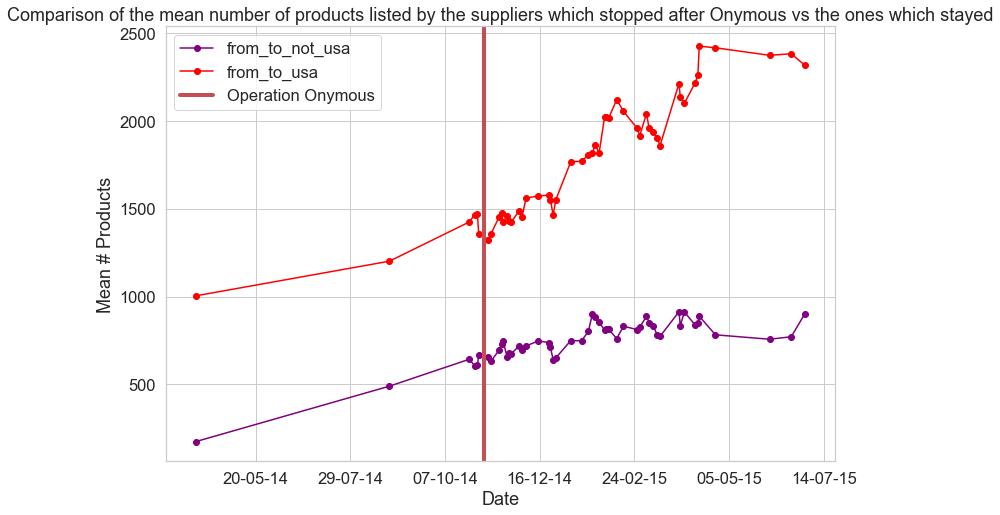

In [31]:
test['date'] = pd.to_datetime(test['date'],infer_datetime_format=True) 
test = test.sort_values(by='date', ascending=True, na_position='first')
from_usa = test[test['from'] == "usa"]
from_to_usa = from_usa[from_usa['to'] == "usa"].groupby('date').count()
from_to_not_usa = from_usa[from_usa['to'] != "usa"].groupby('date').count()


# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(from_to_not_usa.index,
        from_to_not_usa.name,
        '-o',
        color='purple',
        label='from_to_not_usa')
ax.plot(from_to_usa.index,
        from_to_usa.name,
        '-o',
        color='red',
       label='from_to_usa')



ax.set(xlabel="Date", ylabel="Mean # Products",
       title="Comparison of the mean number of products listed by the suppliers which stopped after Onymous vs the ones which stayed")

plt.axvline(linewidth=4, color='r', x="2014-11-05", label="Operation Onymous")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend()
plt.show()
#plotNDate(from_to_not_usa.index,from_to_not_usa.name, 10,"Total number of active vendors per day", "# of vendors")

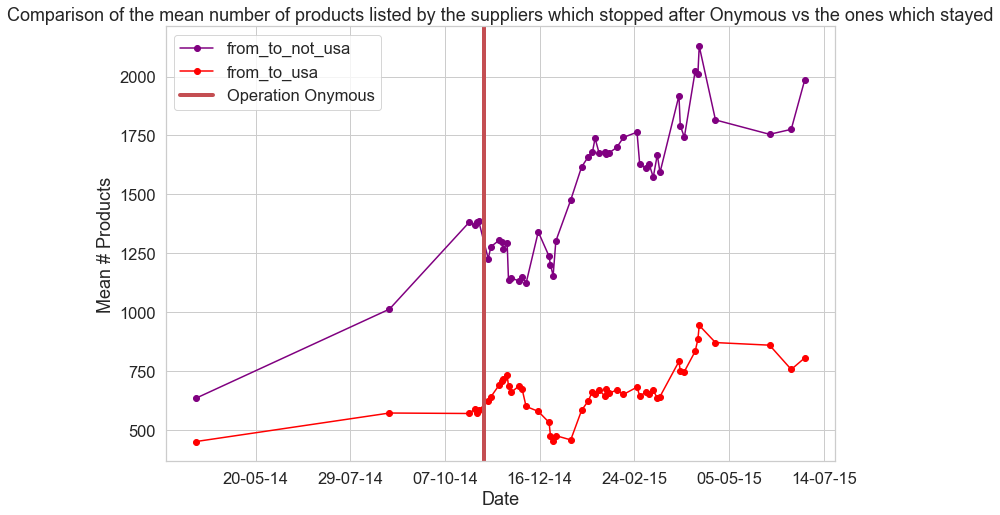

In [36]:
from_usa = test[test['from'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])]
from_to_usa = from_usa[from_usa['to'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])].groupby('date').count()
from_to_not_usa = from_usa[~from_usa['to'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])].groupby('date').count()


# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(from_to_not_usa.index,
        from_to_not_usa.name,
        '-o',
        color='purple',
        label='from_to_not_usa')
ax.plot(from_to_usa.index,
        from_to_usa.name,
        '-o',
        color='red',
       label='from_to_usa')



ax.set(xlabel="Date", ylabel="Mean # Products",
       title="Comparison of the mean number of products listed by the suppliers which stopped after Onymous vs the ones which stayed")

plt.axvline(linewidth=4, color='r', x="2014-11-05", label="Operation Onymous")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend()
plt.show()
#plotNDate(from_to_not_usa.index,from_to_not_usa.name, 10,"Total number of active vendors per day", "# of vendors")

In [44]:
from_usa = test[test['from'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])]
from_usa[from_usa['to'] == 'worldwide'].count()


date    75358
name    75358
cat     75358
to      75358
from    75358
dtype: int64

In [72]:
date = merged_inner['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
countries = ['europe','bulgaria', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
countries_to = ['worldwide','europe','usa', 'bulgaria', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
test = df.select('date', 'name', 'cat', "from", pyspark.sql.functions.explode(col("to")).alias("to")).filter(~col('to').isin("None"))
test = test.select('date', 'name', 'cat', "to", pyspark.sql.functions.explode(col("from")).alias("from")).filter(~col('from').isin("None"))
test = test.filter(col('date').isin(date.tolist()))
test = test.filter(col('from').isin(countries))
test.count()

115745

In [73]:
test.groupby("to").count().orderBy(desc("count")).show(200, False)

+------------------------------------+-----+
|to                                  |count|
+------------------------------------+-----+
|worldwide                           |75401|
|europe                              |16062|
|uk                                  |10174|
|germany                             |3256 |
|sweden                              |2899 |
|worldwideexceptaustralia            |1793 |
|worldwideexceptusa                  |878  |
|ukandeu                             |839  |
|france                              |521  |
|worldnoaustralia                    |479  |
|europeandgermany                    |416  |
|germanyandeurope                    |291  |
|worldwideexceptrussia               |251  |
|worldwidenoaustralia                |249  |
|worldwideexceptsaustralia           |236  |
|usa                                 |126  |
|wordlwideexceptaustralia            |114  |
|worldwideexceptaus                  |103  |
|worldexceptaustralia                |102  |
|europeexp

In [298]:
# usa -> usa : 88928
# usa ->x usa : 38593
# europe ->x europe: 121144
# europe -> europe: 33000

import pyspark
after_top = after.select(pyspark.sql.functions.explode(col("to")).alias("to")).groupby("to").agg(count("to")).toPandas()
after_top = after_top.sort_values(by='count(to)', ascending=False, na_position='first')
after_top = after_top.set_index("to")
#plot = after_top.nlargest(20, "count(to)").plot.pie(y='count(to)', figsize=(15, 15))


In [299]:
before_top = before.select(pyspark.sql.functions.explode(col("to")).alias("to")).groupby("to").agg(count("to")).toPandas()
before_top = before_top.sort_values(by='count(to)', ascending=False, na_position='first')
before_top = before_top.set_index("to")
#plot = before_top.nlargest(20, "count(to)").plot.pie(y='count(to)', figsize=(15, 15))

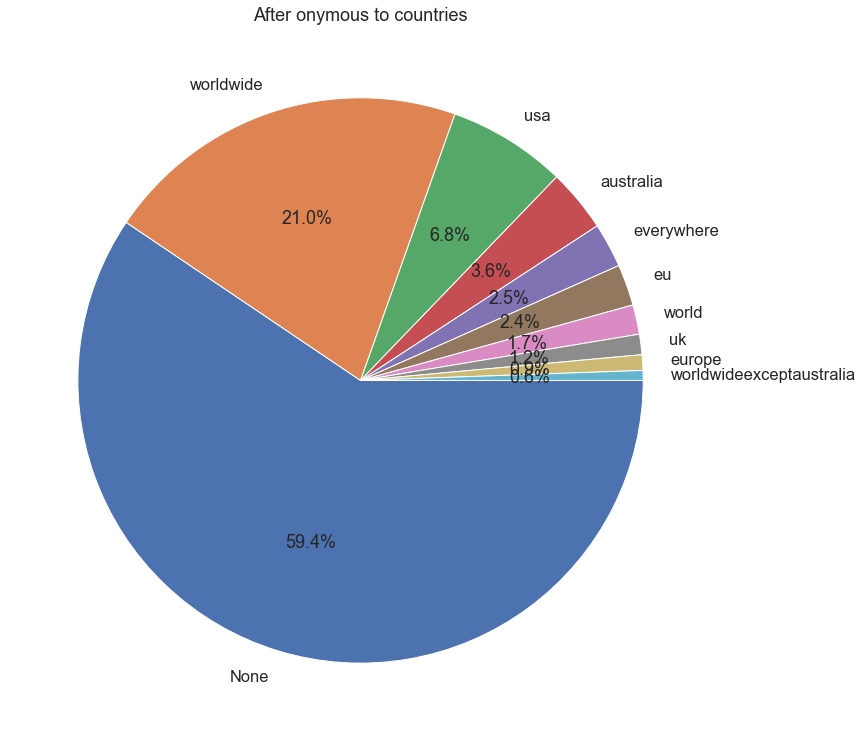

In [300]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(16,13))
top20 = after_top.nlargest(10, "count(to)")
values = top20['count(to)'].values
labels = top20.index
explode = np.zeros(len(values))
plt.pie(values, labels=labels,
explode=explode, autopct='%1.1f%%',
counterclock=False, shadow=False)
plt.title('After onymous to countries')
plt.show()

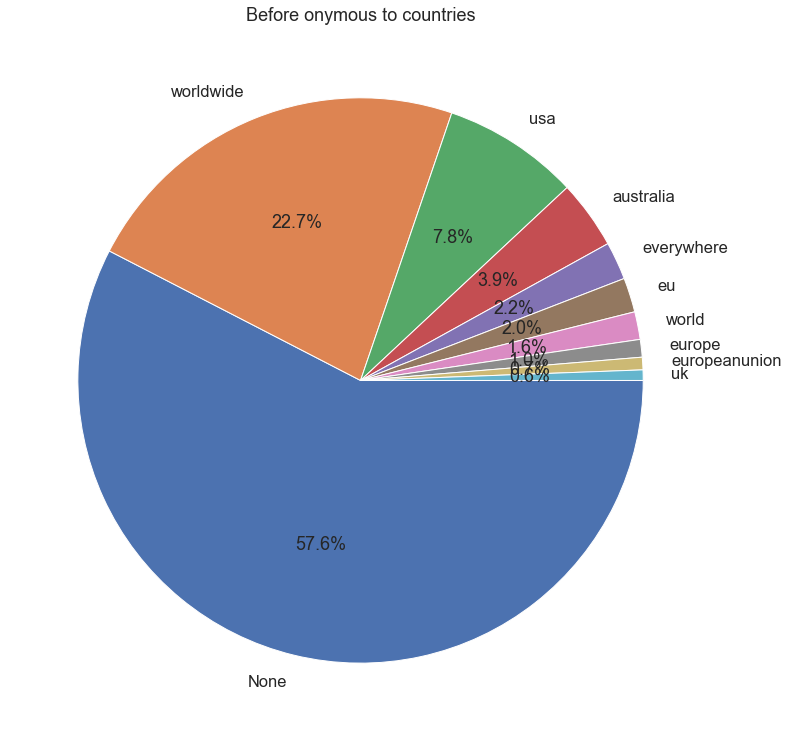

In [301]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(16,13))
top20 = before_top.nlargest(10, "count(to)")
values = top20['count(to)'].values
labels = top20.index
explode = np.zeros(len(values))
plt.pie(values, labels=labels,
explode=explode, autopct='%1.1f%%',
counterclock=False, shadow=False)
plt.title('Before onymous to countries')
plt.show()

In [285]:
before = before.groupby("from").agg(count("from").alias("before_count"))
after = after.groupby("from").agg(count("from").alias("after_count"))
before.join(after, after['from'] == before['from'], "inner").show()

+--------------------+------------+--------------------+-----------+
|                from|before_count|                from|after_count|
+--------------------+------------+--------------------+-----------+
|         [australia]|        1138|         [australia]|       1126|
|           [ukraine]|         108|           [ukraine]|        108|
|            [poland]|          55|            [poland]|         45|
|[uk, usa, philipp...|          62|[uk, usa, philipp...|         62|
|     [americansamoa]|           1|     [americansamoa]|          1|
|           [austria]|          27|           [austria]|         27|
|        [everywhere]|           1|        [everywhere]|          1|
|              [None]|        2190|              [None]|       2328|
|               [you]|           2|               [you]|          2|
|       [switzerland]|          24|       [switzerland]|         14|
|          [hongkong]|         203|          [hongkong]|        182|
|             [india]|         200

In [77]:
join = before.join(after, after.col == before.col, "inner")
join.withColumn("Sub", col("before_count")-col("after_count")).show(300)

+--------------------+------------+--------------------+-----------+----+
|                 col|before_count|                 col|after_count| Sub|
+--------------------+------------+--------------------+-----------+----+
|           australia|         683|           australia|        621|  62|
|            globally|           1|            globally|          1|   0|
|           instagram|           2|           instagram|          2|   0|
|                  us|          23|                  us|         21|   2|
|   mostpartsofeurope|           4|   mostpartsofeurope|          3|   1|
|        unitedstates|          16|        unitedstates|         19|  -3|
|  worldwidepriorfree|           1|  worldwidepriorfree|          1|   0|
|     internationally|          12|     internationally|         18|  -6|
|          everywhere|         378|          everywhere|        442| -64|
|              usonly|           3|              usonly|          3|   0|
|europeexpectscand...|           6|eur

In [17]:
test.show(300, False)

+--------------------------------------------------------------------------------+-----------+
|from                                                                            |count(from)|
+--------------------------------------------------------------------------------+-----------+
|[aruba]                                                                         |1          |
|[finland]                                                                       |265        |
|[uk, asia]                                                                      |210        |
|[kman]                                                                          |2          |
|[responsibleninjas]                                                             |23         |
|[you-freeshipping]                                                              |10         |
|[australia]                                                                     |177946     |
|[greece]                                         

# 4) Plan

##  4.1) Research questions

Due to the large amount of time needed to process the data and handle missing data, we will restrict a bit our research questions : 

* How did it affect the global sales on a short and a longer timescale ?
* How was the user traffic affected ?
* How was the "online traffic" popularity affected ?
* Were there any trends in the forums during this kind of intervention ?
* How did the prices evolve globally ?




## 4.2) Potential issues

The main issues of this project are caused by the missing data, it is very complicated to give meaningful information when we cannot be certain that we cover all the services.

## 4.3) Plannification

  - #### Dec 2th
  Data enrichment 
  Depth analysis of the data.
  Answer research questions.
  - #### Dec 9th
  Create meaningful vizualisation for the results.
  Put all together in a beautiful data story.
  - #### Dec 17th
  Finish producing content for the data story.

  ***
  - #### Dec 20th DEADLINE
  Finalize the data story for submission.
  ***